![title](./img/titanic_meme.jpg)

# Explaining model predictions with PDPs, ICE plots, MDI, PFI and SHAP

*Elliot Coyne and Sammi Rosser, HSMA Trainer*

The notebook below is a modified version of the original by Mike Allen's [Titanic Notebooks](https://github.com/MichaelAllen1966/titanic).

Shapley values provide an estimate of how much any particular feature influences the model decision (prediction). When Shapley values are averaged they provide a measure of the overall influence of a feature.

Shapley values may be used across model types, and so provide a *model-agnostic* measure of a feature's influence. This means that the influence of features may be compared across model types, and it allows *black box* models like neural networks to be explained, at least in part.

Here we will demonstrate Shapley values with random forests.

For more on Shapley values in general see Chris Molner's excellent book chapter:

https://christophm.github.io/interpretable-ml-book/shapley.html

The `shap` package is installed if you have used the `ml` environment yaml file, but otherwise may be installed with `pip install shap`.

More information on the `shap` library, inclusiong lots of useful examples may be found at: https://shap.readthedocs.io/en/latest/index.html

Here we provide an example of using `shap` with Random Forests.

Shap values are returned in a slightly different way to logistic regression  - there is a set of Shap values for each classification probablility ('not survive', 'survive') so we need slightly different syntax to access and use the Shap values.

## Load data and fit model

### Load modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import machine learning methods
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay, permutation_importance

# Import shap for shapley values
import shap

# JavaScript Important for the interactive charts later on
shap.initjs()

### Load data

The section below downloads pre-processed data, and saves it to a subfolder (from where this code is run).
If data has already been downloaded that cell may be skipped.

Code that was used to pre-process the data ready for machine learning may be found at:
https://github.com/MichaelAllen1966/1804_python_healthcare/blob/master/titanic/01_preprocessing.ipynb

In [21]:
download_required = False # Set to True if data needs downloading

if download_required:

    # Download processed data:
    address = 'https://raw.githubusercontent.com/MichaelAllen1966/' + \
                '1804_python_healthcare/master/titanic/data/processed_data.csv'

    data = pd.read_csv(address)

    # Create a data subfolder if one does not already exist
    import os
    data_directory ='./datasets/'
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)

    # Save data
    data.to_csv(data_directory + 'processed_data.csv', index=False)

In [2]:
data = pd.read_csv('datasets/processed_data.csv')
# Make all data 'float' type
data = data.astype(float)

### Divide into X (features) and y (labels)

We will separate out our features (the data we use to make a prediction) from our label (what we are truing to predict).
By convention our features are called `X` (usually upper case to denote multiple features), and the label (survived or not) `y`.

In [4]:
# Use `survived` field as y, and drop for X
y = data['Survived'] # y = 'survived' column from 'data'
X = data.drop('Survived', axis=1) # X = all 'data' except the 'survived' column

# Drop PassengerId
X.drop('PassengerId',axis=1, inplace=True)

### Divide into training and tets sets

When we test a machine learning model we should always test it on data that has not been used to train the model.
We will use sklearn's `train_test_split` method to randomly split the data: 75% for training, and 25% for testing.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    test_size=0.25)

### Fit Random Forest model

In [6]:
model = RandomForestClassifier(n_estimators=100,
                               n_jobs=-1,
                               class_weight='balanced',
                               random_state=42,
                               max_depth=7)

model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=7, n_jobs=-1,
                       random_state=42)

### Predict values and get probabilities of survival

Now we can use the trained model to predict survival. We will test the accuracy of both the training and test data sets.

In [7]:
# Predict training and test set labels
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Predict probabilities of survival
y_prob_train = model.predict_proba(X_train)
y_prob_test = model.predict_proba(X_test)

### Calculate accuracy

In this example we will measure accuracy simply as the proportion of passengers where we make the correct prediction. In a later notebook we will look at other measures of accuracy which explore false positives and false negatives in more detail.

In [8]:
accuracy_train = np.mean(y_pred_train == y_train)
accuracy_test = np.mean(y_pred_test == y_test)

print (f'Accuracy of predicting training data = {accuracy_train:.2%}')
print (f'Accuracy of predicting test data = {accuracy_test:.2%}')

Accuracy of predicting training data = 88.92%
Accuracy of predicting test data = 81.17%


## Examining the model importances

As we have used a tree-based model, we can easily pull out the feature importances using the MDI (mean decrease in impurity) approach, which are stored in `model.feature_importances_`.

In [9]:
feature_names = X.columns.tolist()

feature_importances_mdi = model.feature_importances_

importances = pd.DataFrame(index=feature_names)
importances['importance_mdi'] = feature_importances_mdi
importances['rank'] = importances['importance_mdi'].rank(ascending=False).values

# View just the top 5
importances.sort_values('rank').head()

,importance_mdi,rank
male,0.348332,1.0
Fare,0.148776,2.0
Age,0.116987,3.0
Pclass,0.074443,4.0
CabinNumber,0.063805,5.0


The three most influential features are:

* *male*
* *Fare*
* *age*

Note: random forest importances do not tell us anything about the direction of effect of features (as with random forests, the direction of effect may depend on the value oif other features).

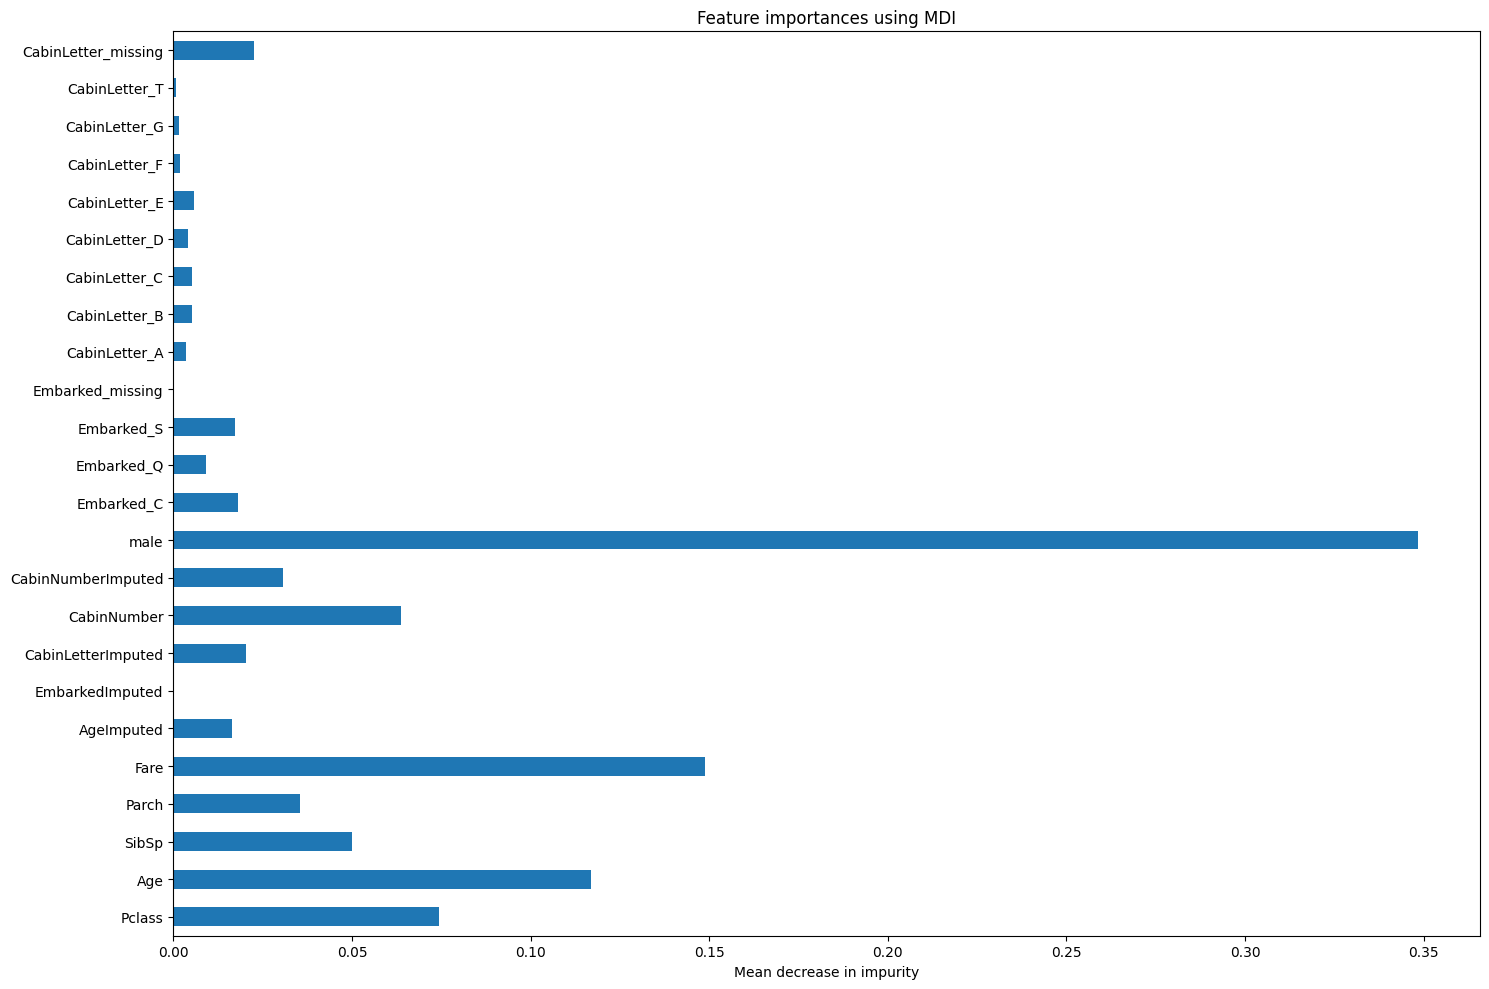

In [10]:
feature_importances_mdi = pd.Series(feature_importances_mdi, index=feature_names)

fig, ax = plt.subplots(figsize=(15,10))
feature_importances_mdi.plot.barh(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_xlabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

Note that because we're using a random forest here, MDI is averaged across all the trees, so we can actually include error bars.

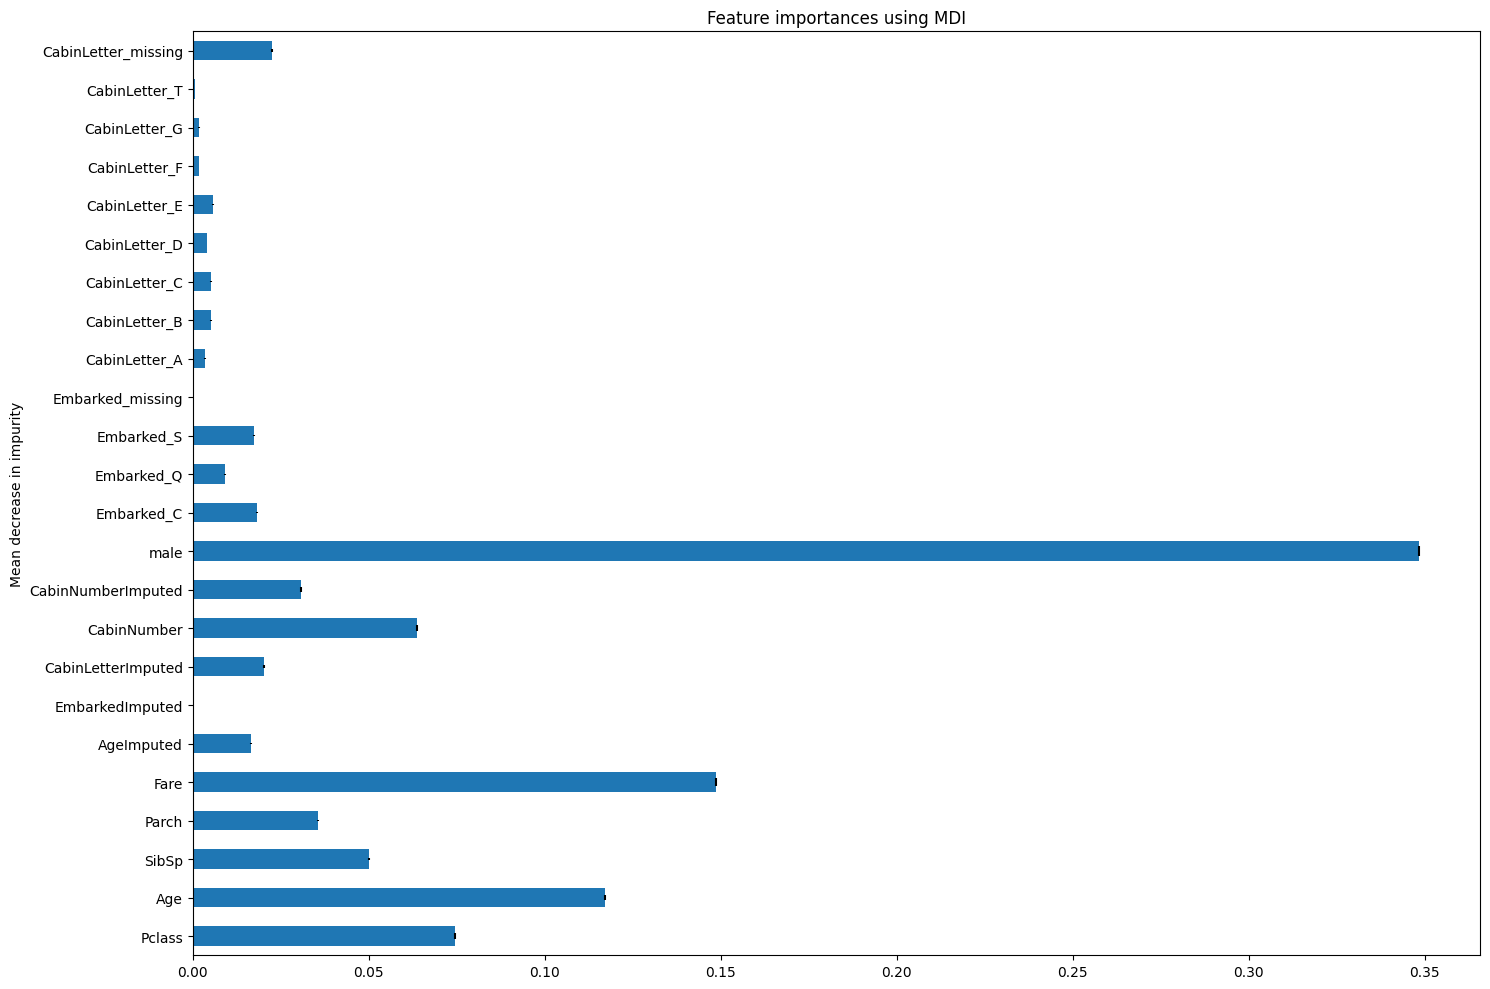

In [11]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots(figsize=(15,10))
forest_importances.plot.barh(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Note that we could also use _permutation feature importance_ here as an alternative approach. 

This works with tree based models, but is actually a model-agnostic approach. 

Let's take a quick look at the output of that function. 

In [13]:
result_pfi = permutation_importance(
    model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

result_pfi

{'importances_mean': array([ 0.03183857,  0.02331839,  0.01345291,  0.00313901,  0.00224215,
         0.00044843,  0.        , -0.00493274,  0.00538117, -0.00044843,
         0.17399103, -0.00134529, -0.00044843,  0.00269058,  0.        ,
        -0.00493274,  0.00358744, -0.00179372,  0.00044843, -0.00179372,
         0.        ,  0.        ,  0.        , -0.00179372]),
 'importances_std': array([0.00735481, 0.00998702, 0.00567225, 0.00403587, 0.01007722,
        0.00509319, 0.        , 0.00372494, 0.00797147, 0.00678598,
        0.01038192, 0.0063576 , 0.00134529, 0.00831715, 0.        ,
        0.00134529, 0.00179372, 0.00219685, 0.00134529, 0.00219685,
        0.        , 0.        , 0.        , 0.00410993]),
 'importances': array([[ 0.02690583,  0.04035874,  0.02690583,  0.03139013,  0.03587444,
          0.04484305,  0.03139013,  0.01793722,  0.02690583,  0.03587444],
        [ 0.04035874,  0.02690583,  0.03587444,  0.00896861,  0.02690583,
          0.02242152,  0.00896861,  0.0

Now let's plot the output.

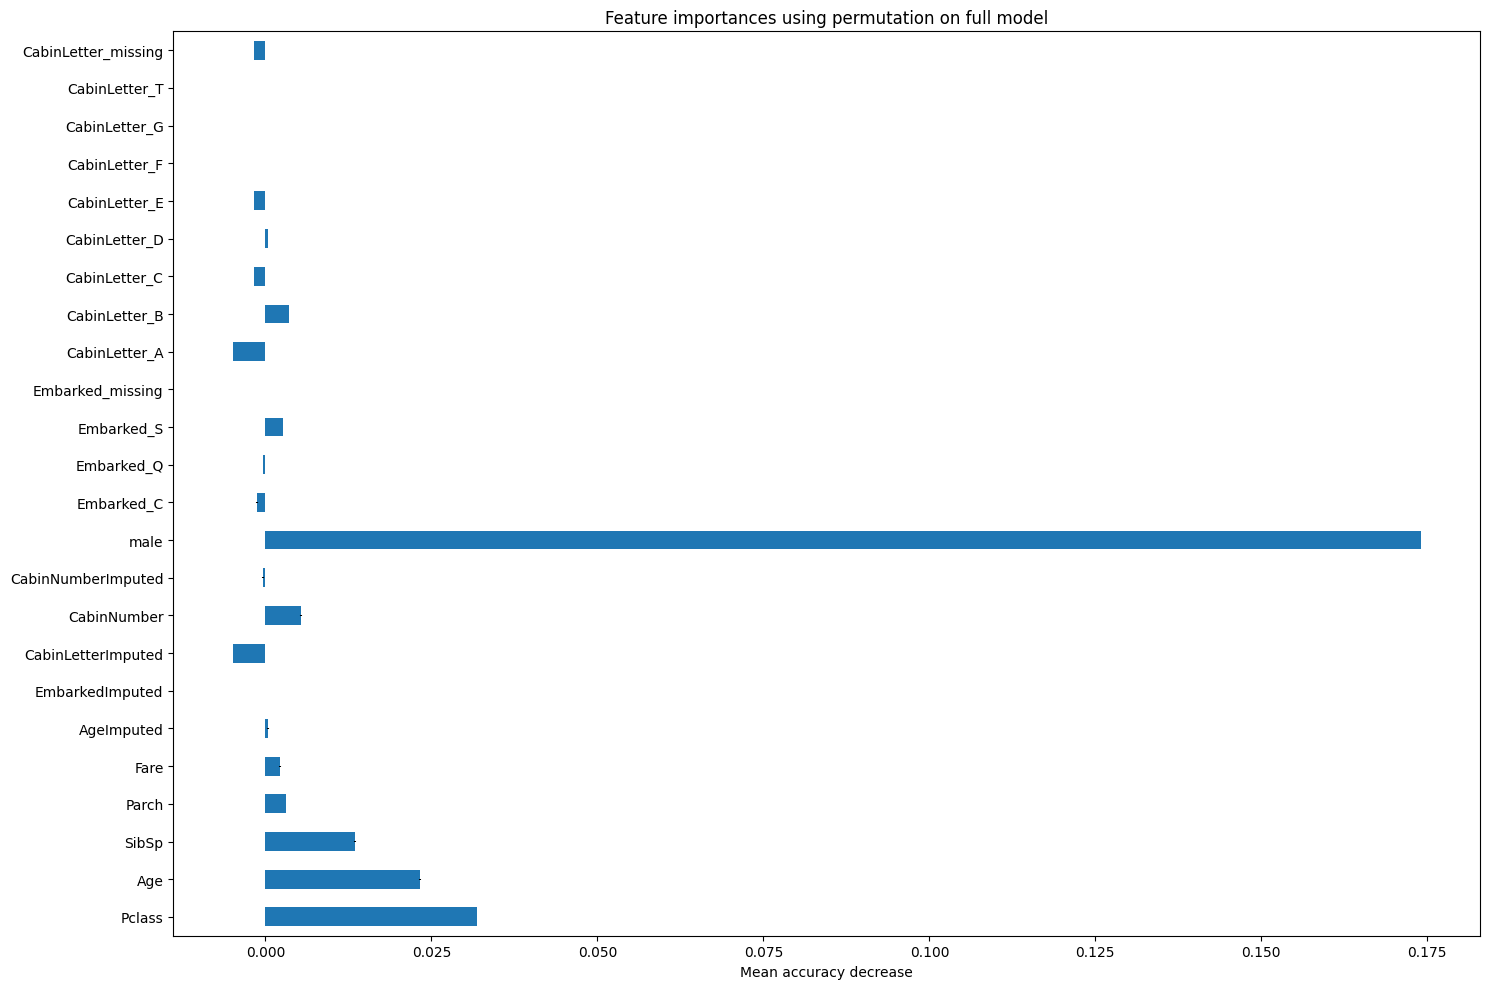

array([7.44432918e-02, 1.16986834e-01, 4.99385280e-02, 3.55346511e-02,
       1.48776346e-01, 1.65428247e-02, 6.34566685e-05, 2.02522718e-02,
       6.38045770e-02, 3.05907944e-02, 3.48332262e-01, 1.81422525e-02,
       9.05385609e-03, 1.72588927e-02, 1.02681115e-04, 3.55987633e-03,
       5.15435767e-03, 5.15584641e-03, 4.00517688e-03, 5.75822924e-03,
       1.72312268e-03, 1.71322993e-03, 6.12277005e-04, 2.24943635e-02])

In [19]:
feature_importances_pfi = pd.Series(result_pfi.importances_mean, index=feature_names)

fig, ax = plt.subplots(figsize=(15,10))
feature_importances_pfi.plot.barh(yerr=result_pfi.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_xlabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()


feature_importances_pfi

Let's add this to our table too. 

In [17]:
importances['importance_pfi'] = feature_importances_pfi
importances['rank_pfi'] = importances['importance_pfi'].rank(ascending=False).values
importances.sort_values('rank_pfi').head()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

## Get Shapley values
First we need to create a shap explainer object. 

In [32]:

explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)
shap_values_numeric = shap_values.values


Look at the explainer object.

In [33]:
explainer

Look at the `shap_values` variable.

In [34]:
type(shap_values)

shap._explanation.Explanation

In [35]:
shap_values

.values =
array([[[ 0.01060336, -0.01060336],
        [ 0.02870872, -0.02870872],
        [-0.00961641,  0.00961641],
        ...,
        [-0.00037315,  0.00037315],
        [ 0.        ,  0.        ],
        [ 0.00809963, -0.00809963]],

       [[-0.01520491,  0.01520491],
        [ 0.02459478, -0.02459477],
        [-0.00241162,  0.00241162],
        ...,
        [-0.0004267 ,  0.0004267 ],
        [ 0.        ,  0.        ],
        [ 0.00473834, -0.00473834]],

       [[ 0.01319181, -0.01319181],
        [ 0.01232224, -0.01232224],
        [-0.00262561,  0.00262561],
        ...,
        [-0.00049012,  0.00049012],
        [ 0.        ,  0.        ],
        [-0.00154064,  0.00154064]],

       ...,

       [[ 0.01926633, -0.01926633],
        [ 0.0221672 , -0.0221672 ],
        [-0.00363846,  0.00363846],
        ...,
        [-0.0004621 ,  0.00046211],
        [ 0.        ,  0.        ],
        [ 0.00050243, -0.00050243]],

       [[-0.07960656,  0.07960655],
        [ 0.01078

Look at the `shap_values_numeric` variable.

In [36]:
shap_values_numeric

array([[[ 0.01060336, -0.01060336],
        [ 0.02870872, -0.02870872],
        [-0.00961641,  0.00961641],
        ...,
        [-0.00037315,  0.00037315],
        [ 0.        ,  0.        ],
        [ 0.00809963, -0.00809963]],

       [[-0.01520491,  0.01520491],
        [ 0.02459478, -0.02459477],
        [-0.00241162,  0.00241162],
        ...,
        [-0.0004267 ,  0.0004267 ],
        [ 0.        ,  0.        ],
        [ 0.00473834, -0.00473834]],

       [[ 0.01319181, -0.01319181],
        [ 0.01232224, -0.01232224],
        [-0.00262561,  0.00262561],
        ...,
        [-0.00049012,  0.00049012],
        [ 0.        ,  0.        ],
        [-0.00154064,  0.00154064]],

       ...,

       [[ 0.01926633, -0.01926633],
        [ 0.0221672 , -0.0221672 ],
        [-0.00363846,  0.00363846],
        ...,
        [-0.0004621 ,  0.00046211],
        [ 0.        ,  0.        ],
        [ 0.00050243, -0.00050243]],

       [[-0.07960656,  0.07960655],
        [ 0.01078217, -0.01

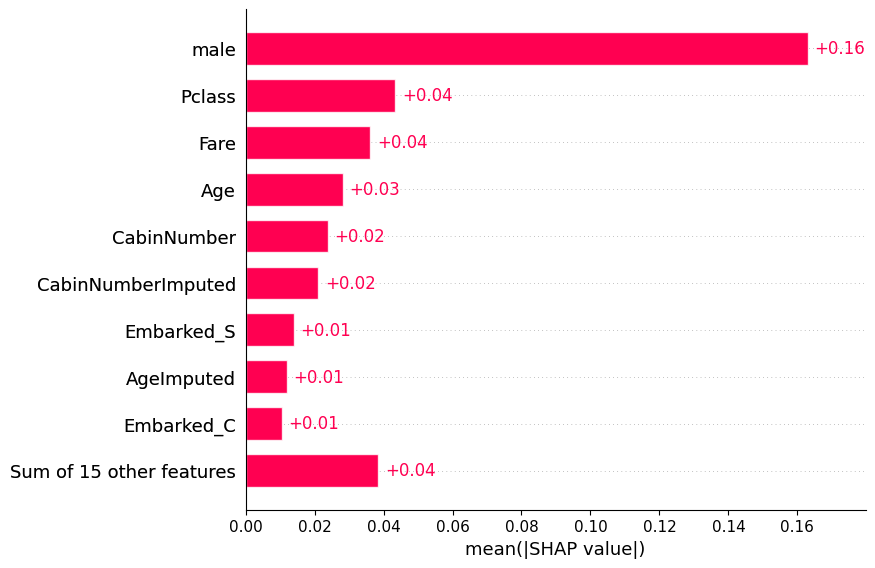

In [37]:
# Random forests seem to give us a slightly different output format,
# so we adjust the line below to just bring back the results from the
# positive class
shap.plots.bar(shap_values[:, :, 1])

Add Shap values to coefficient table.

In [38]:
# Calculate mean Shap value for each feature in training set
importances['mean_shap_values'] = np.mean(shap_values_numeric[:,:,1], axis=0)

# Calculate mean absolute Shap value for each feature in training set
# This will give us the average importance of each feature
importances['mean_abs_shap_values'] = np.mean(
    np.abs(shap_values_numeric[:,:,1]),axis=0)

importances['rank_shap'] = importances['mean_abs_shap_values'].rank(ascending=False).values
importances.sort_values('rank_shap').head()

,importance_mdi,rank,importance_pfi,rank_pfi,mean_shap_values,mean_abs_shap_values,rank_shap
male,0.348332,1.0,0.173991,1.0,0.009733,0.163071,1.0
Pclass,0.074443,4.0,0.031839,2.0,0.011423,0.043382,2.0
Fare,0.148499,2.0,0.000897,9.0,0.001480,0.036203,3.0
Age,0.116853,3.0,0.023318,3.0,-0.013086,0.028130,4.0
CabinNumber,0.064082,5.0,0.005381,5.0,0.005358,0.023901,5.0


Get top 10 influential features by co-efficients for SHAP

In [39]:
# Get top 10 features
mdi_importance_top_10 = \
    importances.sort_values(by='importance_mdi', ascending=False).head(10).index

pfi_importance_top_10 = \
    importances.sort_values(by='importance_pfi', ascending=False).head(10).index

shapley_top_10 = \
    importances.sort_values(
    by='mean_abs_shap_values', ascending=False).head(10).index

# Add to DataFrame
top_10_features = pd.DataFrame()
top_10_features['importances_mdi'] = mdi_importance_top_10.values
top_10_features['importances_pfii'] = pfi_importance_top_10.values
top_10_features['Shap'] = shapley_top_10.values

# Display
top_10_features

,importances_mdi,importances_pfii,Shap
0,male,male,male
1,Fare,Pclass,Pclass
2,Age,Age,Fare
3,Pclass,SibSp,Age
4,CabinNumber,CabinNumber,CabinNumber
5,SibSp,CabinLetter_B,CabinNumberImputed
6,Parch,Parch,Embarked_S
7,CabinNumberImputed,Embarked_S,AgeImputed
8,CabinLetter_missing,Fare,Embarked_C
9,CabinLetterImputed,AgeImputed,SibSp


Let's quickly compare our shap top 10 with the associated bar plot.

We can see a lot of overlap between the most import fatures as estimated by coefficients and those estimated using mean absolute Shapley values. But they are not identical.

Plot comparison of Shapley and model coefficients:

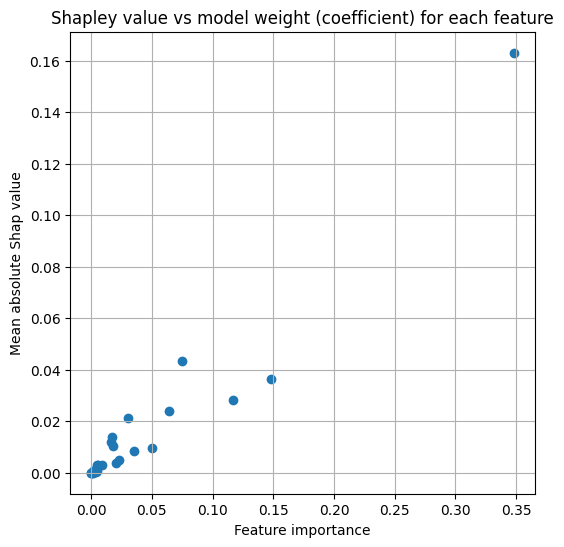

In [40]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

# Plot points
x = importances['importance_mdi']
y = importances['mean_abs_shap_values']

ax.scatter(x, y)
ax.set_title('Shapley value vs model weight (coefficient) for each feature')
ax.set_ylabel('Mean absolute Shap value')
ax.set_xlabel('Feature importance')

plt.grid()
plt.show()

# Partial Dependence Plots (PDPs) and Individual Conditional Expectation (ICE) Plots



### A single PDP

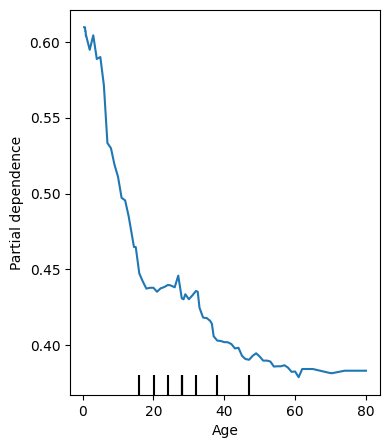

In [41]:
fig, ax = plt.subplots(figsize=(4, 5)) # Create an empty plot, specifying size

display = PartialDependenceDisplay.from_estimator(
    model,  # Your fitted model
    X_train,  # Your feature matrix
    features=['Age'],  # List of features to plot
    kind='average',  # Type of plot
    ax=ax, # axis to plot on
    random_state=42 # avoidance of randomness
)

plt.show()

### 2 PDPs side-by-side 

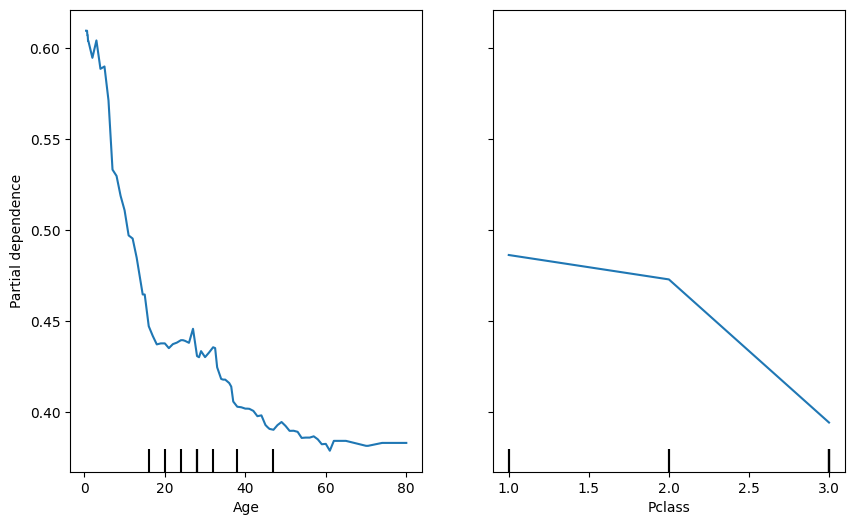

In [42]:
fig, ax = plt.subplots(figsize=(10, 6))
display = PartialDependenceDisplay.from_estimator(
    model,  # Your fitted model
    X_train,  # Your feature matrix
    features=['Age', 'Pclass'],  # List of features to plot
    kind='average',  # Type of PDP
    ax=ax,
    random_state=42
)
plt.show()

### A single ICE plot

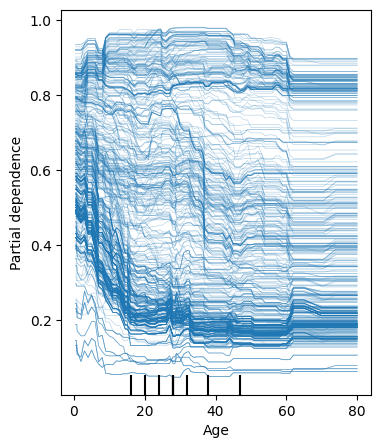

In [43]:
fig, ax = plt.subplots(figsize=(4, 5)) # Create an empty plot, specifying size

display = PartialDependenceDisplay.from_estimator(
    model,  # Your fitted model
    X_train,  # Your feature matrix
    features=['Age'],  # List of features to plot
    kind='individual',  # Type of plot
    ax=ax, # axis to plot on
    random_state=42 # avoidance of randomness
)
plt.show()

An ICE plot for a subsample of people

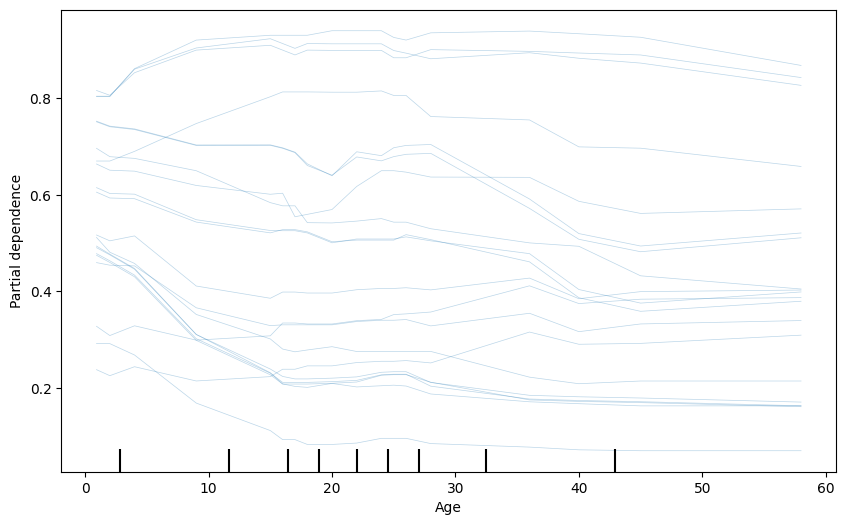

In [44]:
fig, ax = plt.subplots(figsize=(10, 6))
display = PartialDependenceDisplay.from_estimator(
    model,  # Your fitted model
    X_train.sample(20),  # Your feature matrix
    features=['Age'],  # List of features to plot
    kind='individual',  # Type of PDP
    ax=ax,
    random_state=42
)
plt.show()

The plot below shows an alternative way to subsample to just a subset of the data.

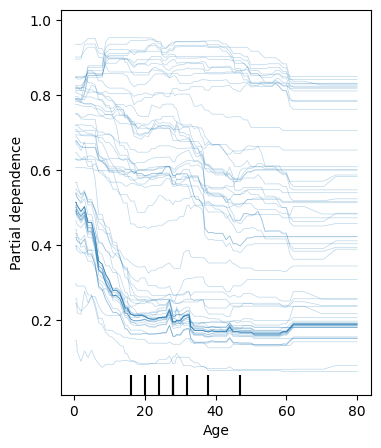

In [45]:
fig, ax = plt.subplots(figsize=(4, 5)) # Create an empty plot, specifying size

display = PartialDependenceDisplay.from_estimator(
    model,  # Your fitted model
    X_train,  # Your feature matrix
    subsample=0.1, # Proportion of data to subsample down to
    features=['Age'],  # List of features to plot
    kind='individual',  # Type of plot
    ax=ax, # axis to plot on
    random_state=42 # avoidance of randomness
)
plt.show()

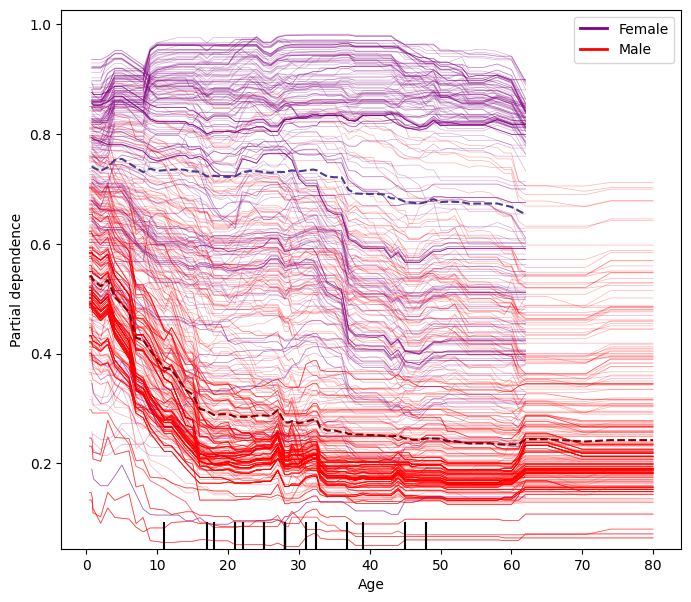

In [46]:
fig, ax = plt.subplots(figsize=(8, 7)) # Create an empty plot, specifying size

display = PartialDependenceDisplay.from_estimator(
    model,  # Your fitted model
    X_train[X_train['male'] == 1],  # Your feature matrix
    features=['Age'],  # List of features to plot
    kind='both',  # Type of plot
    ax=ax, # axis to plot on
    random_state=42, # avoidance of randomness
    ice_lines_kw={'color': 'red'},
    pd_line_kw={'color': 'maroon'}
)

PartialDependenceDisplay.from_estimator(
    model,  # Your fitted model
    X_train[X_train['male'] == 0],  # Your feature matrix
    features=['Age'],  # List of features to plot
    kind='both',  # Type of plot
    ax=display.axes_, # axis to plot on
    random_state=42, # avoidance of randomness
    ice_lines_kw={'color': 'purple'},
    pd_line_kw={'color': 'darkslateblue'}
)

# Create custom legend handles and labels
legend_elements = [
    plt.Line2D([0], [0], color='purple', lw=2, label='Female'),
    plt.Line2D([0], [0], color='red', lw=2, label='Male')
]

# Add the legend
plt.legend(handles=legend_elements, loc="upper right")
plt.show()

### 2 ICE Plots side-by-side

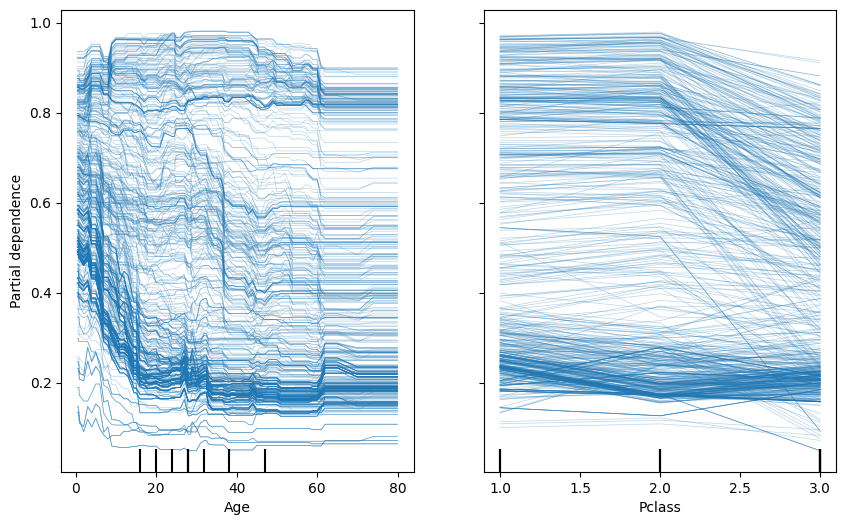

In [47]:
fig, ax = plt.subplots(figsize=(10, 6))
display = PartialDependenceDisplay.from_estimator(
    model,  # Your fitted model
    X_train,  # Your feature matrix
    features=['Age', 'Pclass'],  # List of features to plot
    kind='individual',  # Type of PDP
    ax=ax,
    random_state=42
)
plt.show()

### Joint PDP/ICE Plot

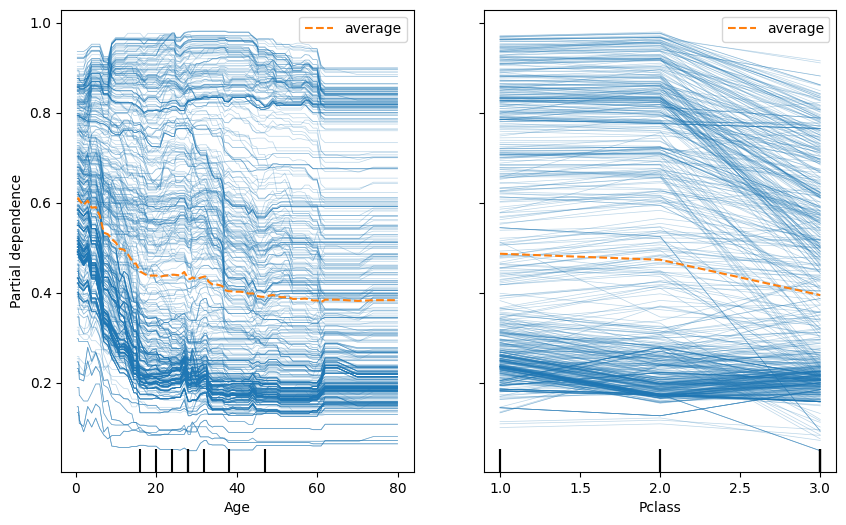

In [48]:
fig, ax = plt.subplots(figsize=(10, 6))
display = PartialDependenceDisplay.from_estimator(
    model,  # Your fitted model
    X_train,  # Your feature matrix
    features=['Age', 'Pclass'],  # List of features to plot
    kind='both',  # Type of PDP
    ax=ax,
    random_state=42
)
plt.show()

### Bonus: 2D PDP!

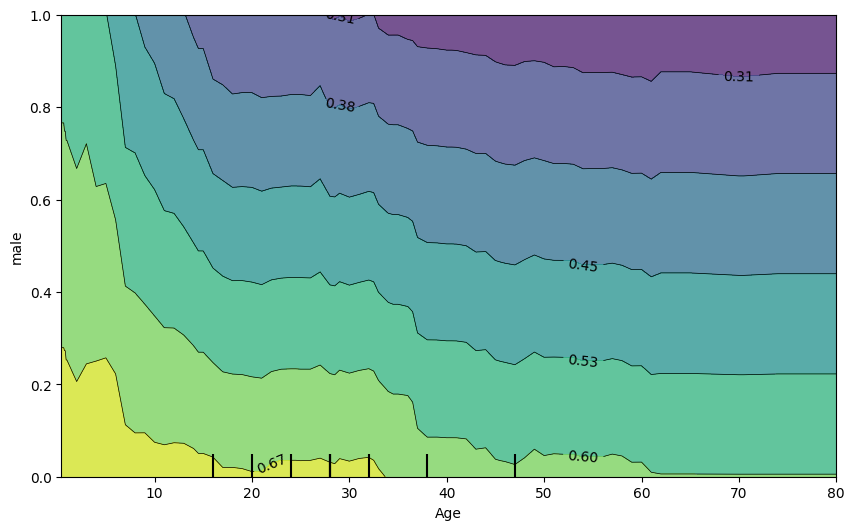

In [49]:
fig, ax = plt.subplots(figsize=(10, 6))
display = PartialDependenceDisplay.from_estimator(
    model,  # Your fitted model
    X_train,  # Your feature matrix
    features=[('Age', 'male')],  # List of features to plot
    kind='average',  # Type of PDP
    ax=ax,
    random_state=42
)
plt.show()

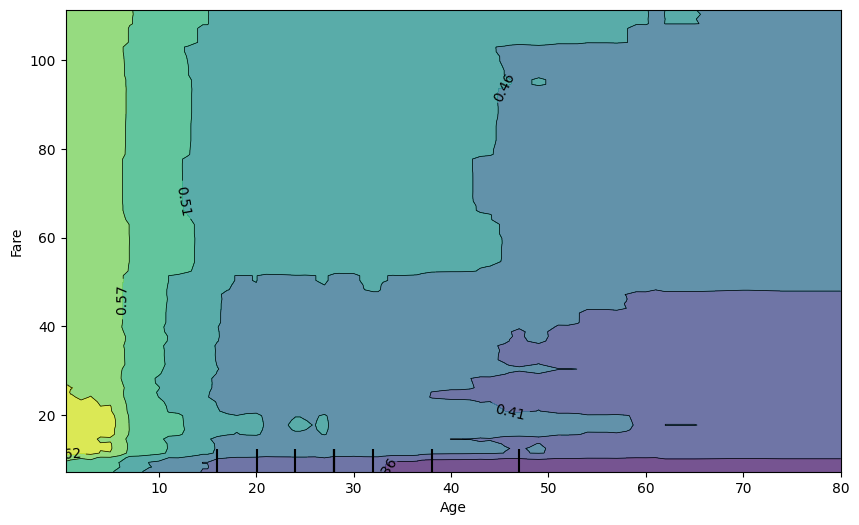

In [50]:
fig, ax = plt.subplots(figsize=(10, 6))
display = PartialDependenceDisplay.from_estimator(
    model,  # Your fitted model
    X_train,  # Your feature matrix
    features=[('Age', 'Fare')],  # List of features to plot
    kind='average',  # Type of PDP
    ax=ax,
    random_state=42
)
plt.show()